# Exercise: Convolutional Neural Networks - Solution
$\renewcommand{\real}{\mathbb{R}}$
$\newcommand{\xb}{\mathbf{x}}$
$\newcommand{\yb}{\mathbf{y}}$
$\newcommand{\zb}{\mathbf{z}}$
$\newcommand{\wb}{\mathbf{w}}$
$\newcommand{\Xb}{\mathbf{X}}$
$\newcommand{\Lb}{\mathbf{L}}$
$\renewcommand{\argmin}{argmin}$

In this exercise session, we will learn about PyTorch, one of the most used framework for deep learning in python. We will use it to implement our own neural networks and train them through gradient descent.


## Dependencies

Before you start, please make sure to install the following packages:

**torch**: The framework we will use for training deep nets, with useful sub-modules `torch.nn` and `torch.nn.functional` that we import below.

**torchvision**: Helper package consisting of popular datasets, model architectures, and common image transformations for computer vision. We will use it for loading the MNIST dataset and to perform simple data transformations.

**torchsummary**: Helper package for visualizing deep net architectures.

Please use the following commands in your terminal to install all the dependencies:

`pip install torch torchvision torchsummary`

`conda install -c conda-forge nomkl`

In [1]:
# 3rd party
import numpy as np

# We import PyTorch and some of its internal modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose
from torchsummary import summary
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Project files.
from helpers import accuracy, DrawingPad

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

## Part 1: PyTorch

### 1.1: Motivation

In the first part of the exercise we will revisit the MNIST dataset of hand-written digits, and we will train deep net models to classify the digits. Instead of doing all the hard coding work manually, we will simplify our life by using a deep learning framework: PyTorch.

Last week we have implemented our own Multi-Layer Perceptron (MLP), where we defined both the forward pass and back-propagation together with a simple optimizer (SGD update rule) and successfully trained it to perform classification. Given the amount of code written, one can imagine that prototyping with various NN architectures and training strategies might get tedious. That is where PyTorch (and other deep learning frameworks) come into play.

### 1.2: About PyTorch

[PyTorch](https://pytorch.org/) is an optimized tensor library for deep learning using GPUs and CPUs. It allows
for fast prototyping by providing high-level access to all necessary building blocks, including NN layers, activation functions, loss functions, and optimizers, to name a few. Most importantly, however, PyTorch implements the [autograd](https://pytorch.org/docs/stable/autograd.html) package, which allows for automatic differentiation of the operations we use to define NN architectures. In other words, one only has to implement the forward pass, namely to combine desired layers, while the **backpropagation is computed automatically**.

### 1.3: Basic pipeline

To define and train deep net models, one would usually implement the following steps:

    1. Load the dataset.
    2. Define and instantiate a deep net architecture.
    3. Choose or implement a loss function (such as the mean squared error).
    4. Choose and instantiate an optimizer (such as the SGD).
    5. For each batch in the dataset:
        5.1. Load a batch.
        5.2. Run a forward pass through your model.
        5.3. Compute the loss.
        5.4. Run a backward pass, i.e., compute gradients of the loss w.r.t. the trainable parameters (weights).
        5.5. Update the weights using the optimizer.
        5.6. Zero-out the accumulated gradients before the next iteration.
        
We will see this exact pipeline in our code as well.

### 1.4: Essential bulding blocks

This section gives a high-level summary of the most important components representing the bare minimum that you will need to start playing with PyTorch and deep net models. You might want to skim through the official tutorials as well, namely [What is PyTorch](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py) and [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py). Here is the list of the components that will be explained in more detail along with the code blocks.

  - **nn.Module**: Base class for NN architectures.
  - **criterion**: A loss function.
  - **backward-pass**: Derivatives computed by the auto-diff system.
  - **optimizer**: Updates the trainable parameters (weights) during training.

### 1.5: Loading the data

We are at step (1) of the training pipeline where we prepare the data. In PyTorch, loading the data is traditionally performed by creating:
* a *dataset* that manages the loading and transformations of the data
* and a *dataloader* that is a Python *iterator*, which returns the batches of data and associated labels from our dataset.

PyTorch provides us with the `Dataset` and `DataLoader` classes for this.

As was the case of previous week, we will work with the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, where each sample is stored as a $28 \times 28$ pixels grayscale image. The data samples are loaded as `torch.Tensor` data type, multi-dimentional matrices similar to `numpy.ndarray`.

`MNIST` below is a sub-class of `Dataset`, which will download the dataset when used for the first time. It returns an image $x$ and its true label $y$. The dataloader will then prepare batches out of these images and labels.

In [3]:
batch_size = 128

# Dataset and DataLoader for MLP.
dataset_train = MNIST('data', train=True, download=True, transform=ToTensor())
dataset_test = MNIST('data', train=False, download=True, transform=ToTensor())
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print('Loaded {} train and {} valid samples.'.format(len(dataset_train), len(dataset_test)))

Loaded 60000 train and 10000 valid samples.


### 1.6: Multi-Layer Perceptron (MLP)

#### Architecture

We are at step (2) of the training pipeline. We will start by implementing an MLP consisting of a 1D input layer (we flatten, i.e., vectorize, the input image) of shape ($784$, ), $3$ hidden fully connected layers and an output layer of shape ($10$, ), as we have $10$ classes.

As you saw last week, one layer of an MLP computes the following function:

$$ \yb = \sigma \left(\mathbf{W}^\top\xb + \mathbf{b}\right), $$

where $\sigma$ is the activation, $\mathbf{W}$ is the weight, and $\mathbf{b}$ the bias. The type of layer that computes $\mathbf{W}^\top\xb + \mathbf{b}$ is referred to as *fully-connected* (FC) because every input is connected to every output (recall the MLP diagram from the lectures). Additionally, we also call them *linear* layers because they compute a linear function with respect to their input (plus a bias).

#### Optimization criterion

We would like to interpret the output vector $\hat{\yb} \in \real^{10}$ as the probabilities of data sample $\xb \in \real^{784}$ belonging to each class $j \in \{0, 1, 2, ..., 9\}$. Therefore, we will make use of the activation function **softmax**, defined as

$$ \hat{\yb}^{(j)} = P(\text{class}=j|\zb) = \mathrm{Softmax}_j(\zb) = \frac{\exp{\zb_{(j)}}}{\sum_{k=0}^{9}{\exp{\zb_{(k)}}}}, $$

on the final output of our network $\zb$ (these values pre-softmax are referred to as "logits").
The softmax guarantees that $\sum_{k=0}^{9}{\hat{\yb}_{k}} = 1$ and $\yb_j \geq 0, \, \forall j$, meaning that out predicted vector $\hat\yb$ is indeed a valid probability distribution over classes.

Finally, we would like to match the predicted distribution $\hat{\yb}$ to the ground truth (GT) one $\yb$, where $\yb$ is given as a one-hot encoding ($\yb$ is all zeros except for a $1$ at the index $j$, if $j$ is the correct class to be predicted). The optimization criterion of choice is then to minimize the [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy) (CE) of $\hat{\yb}$ and $\yb$. Therefore our final loss function $L$ is defined as:

$$ L = \text{CE}\left(\hat{\yb}, \yb\right).$$

Thankfully, PyTorch provides the implementation of $L$, **so you will only really need to provide the output $\zb$** (i.e. the 10-dimensional output of your last layer *before* the softmax). We will get back to $L$ later.

---

#### nn.Module
Each custom NN architecture you choose to implement has to subclass the [`nn.Module`](https://pytorch.org/docs/stable/nn.html#module), which conveniently keeps track of all the trainable parameters. From the programmer's perspective, you have to implement the constructor (`__init__`) and override the `forward()` function:

- **\_\_init__()**

You will define your layers (e.g., fully connected layer, 2D convolutional layer, etc.) in the constructor, and `nn.Module` will automatically keep track of all the weights these layers contain.

- **forward()**

This function really defines the architecture, as you will sequentally call your layers in the desired order. Each time you call `forward()` (every training iteration), the so-called **computational graph** is built. It is a directed acyclic graph (DAG) of nodes corresponding to the operations you have called. Each node defines the derivative of its outputs w.r.t. its inputs. The computational graph is then traversed in the reversed fashion once you call `backward()` and the derivatives are computed.

All the trainable parameters, which your model consists of, can be accessed via a call to `model.parameters()` implemented in `nn.Module`. This comes in handy once instantiating your optimizer as you have to pass all the parameters you want it to manage.

---

Your task is to define the MLP as depicted in the figure below. Please refer to the documentation and focus on
the classes `nn.Linear` to define the layers and `F.relu` to call the activation funtion.

<img src="img/mlp.png" width=800></img>

In [4]:
class FC(nn.Module):
    """ Standard Multi layer perceptron for classification into 10 
    classes. Consists of 4 FC layers, ReLU activations are used 
    for the first 3.
    """
    def __init__(self):
        """ Constructor, layers definitions go here. Only specify
        those layers which have any trainable parameters (but for
        instance not the activation functions as the ones we use 
        do not have any trainable parameters). """
        super(FC, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        """ Feed-forward pass, this is where the actual computation happens
        and the computational graph is built (from scratch each time this 
        function is called). """
        # Note: we first flatten the images into vectors
        # This is done over the last 3 dimensions: (channel, height, width)
        x = x.flatten(-3)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)
    
# Instantiate the model.
model_fc = FC()

**Q:** How many learnable parameters (weights) does this model have?

**A:** For each transition between layers $\mathrm{i} \rightarrow \mathrm{i+1}$, the weight matrix has the shape $(M_{i}+1) \times M_{i+1}$, where $M_{i}$ is the number of nodes in the specific hidden layer. The $+1$ in the input dimension stands for the bias term included. The starting dimension of the input is $D+1=785$ and the final dimension of outpus is $C=10$ Thus, the total number of learnable parameters in the model is $(784+1)\times 512 + (512+1)\times 256 + (256+1)\times 128 + (128+1)\times 10 = 567,434$.

### 1.7: Inspecting the model architecture

Let us check the model architecture and see how many trainable parameters we really use. For this purpose we will use the `torchsummary` package.

Note the number of trainable parameters.

In [12]:
summary(model_fc, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 10]           1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.16
Estimated Total Size (MB): 2.17
----------------------------------------------------------------


### 1.8: Loss function

We are at step (3) of our pipeline. As explained above, our loss function $L$ will be $\text{CE}(\hat{\yb}, \yb)$, which is provided for us by PyTorch, please refer to the documentation of [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).

**Note:** as explained above, this function will also directly implement the *Softmax* on the predictions, so you don't need to manually call it.

There are [many commonly used loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) defined in the `torch.nn` module, and you can also implement your own using PyTorch operations. 

Your task is to instantiate the CE loss function.

In [4]:
# Define the loss function.
criterion = nn.CrossEntropyLoss()

### 1.9: Optimizer
We are at step (4) of the pipeline. The [Optimizer](https://pytorch.org/docs/stable/optim.html) updates the weights of the network given their currently computed gradients. It can be a simple state-less function (such as SGD) or a more advanced one that keeps track of additional information about the weights and their gradients (such as a running mean), which can be used for more advanced update rules.

We will opt for the simplest case, the state-less SGD. Your task is to instantiate this optimizer for the parameters (:= weights) of our model, please refer to [`optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [5]:
learning_rate = 1e-1
optimizer = torch.optim.SGD(model_fc.parameters(), lr=learning_rate)

NameError: name 'model_fc' is not defined

### 1.10: Training loop

We are at step (5) of our pipeline. We would like to define a training loop where we iterate over the training samples, predict the outputs, and update the model based on its errors. Let us define a function `train_model()` that will be used for training any network architecture we come up with.

Fill in the code that follows the steps 5.2 - 5.6 of our training pipeline. For running the backward pass, use the function [`backward()`](https://pytorch.org/docs/stable/autograd.html?highlight=backward#torch.autograd.backward). For zeroing out the accumulated gradients, use the function [`zero_grad()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=zero_grad#torch.nn.Module.zero_grad).

In [6]:
def train_model(model, criterion, optimizer, dataloader_train, dataloader_test, epochs):
    for ep in range(epochs):
        # Training.
        model.train()
        for it, batch in enumerate(dataloader_train):
            # 5.1 Load a batch, break it down in images and targets.
            x, y = batch

            # 5.2 Run forward pass.
            logits = model.forward(x) 
            
            # 5.3 Compute loss (using 'criterion').
            loss = criterion(logits, y)
            
            # 5.4 Run backward pass.
            # torch.autograd.backward(loss) |> alternative option
            loss.backward()
            
            # 5.5 Update the weights using optimizer.
            optimizer.step()
            
            # 5.6 Zero-out the accumulated gradients.
            optimizer.zero_grad()

            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}, accuracy train: {:.2f}'.
                  format(ep + 1, epochs, it + 1, len(dataloader_train), loss,
                         accuracy(logits, y)), end='')

        # Validation.
        model.eval()
        with torch.no_grad():
            acc_run = 0
            for it, batch in enumerate(dataloader_test):
                # Get batch of data.
                x, y = batch
                curr_bs = x.shape[0]
                acc_run += accuracy(model(x), y) * curr_bs
            acc = acc_run / len(dataloader_test.dataset)

            print(', accuracy test: {:.2f}'.format(acc))

### Training the model

Let's now use everything that we have prepared to train our model on MNIST:

In [11]:
epochs = 5
train_model(model_fc, criterion, optimizer, dataloader_train, dataloader_test, epochs)

Ep 1/5, it 469/469: loss train: 0.25, accuracy train: 0.93, accuracy test: 0.93
Ep 2/5, it 469/469: loss train: 0.14, accuracy train: 0.95, accuracy test: 0.95
Ep 3/5, it 469/469: loss train: 0.21, accuracy train: 0.95, accuracy test: 0.96
Ep 4/5, it 469/469: loss train: 0.08, accuracy train: 0.97, accuracy test: 0.96
Ep 5/5, it 469/469: loss train: 0.10, accuracy train: 0.98, accuracy test: 0.97


## Part 2: Convolutional Neural Networks (CNNs)

Our 4-layer MLP network works well, reaching a test accuracy of ~0.96. However, this network uses ~0.5M weights. We can use even deeper architectures with fewer parameters and take advantage of the 2D structure of the input data (images) using CNNs.

### 2.1: LeNet-5

Let us define a simple CNN with 2 convolutional layers with max-pooling and 3 FC layers. In particular, we will implement a variant of the architecture called [LeNet-5 introduced by Yann LeCun in 1999](http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf). 


Your task is to define a simple LeNet-5 architecture depicted in the figure below. Print the architecture and comment on the number of parameters. Finally train the model. To specify the layers, please additionally refer to [`Conv2d`](https://pytorch.org/docs/stable/nn.html#conv2d) and [`max_pool2d`](https://pytorch.org/docs/stable/nn.html?highlight=max_pool2d#torch.nn.functional.max_pool2d).

#### A word about **padding**
As you saw in the lecture, a convolution will decrease the size of the signal if we only consider the *valid* convolutions, i.e. when the kernel (or mask) is fully within the input signal. In order to avoid this, we can allow the kernel to go slightly beyond the original signal by padding it with zeros at its beginning and end.

To visualize this, imagine a 1D signal of size $4$ and a kernel of size $3$: we can move the kernel on the input only twice, and the output will then have a size of $2$. However, if we add one $0$ at the beginning and at the end of the input, therefore changing its effective size to $6$, the kernel will be able to move four times over it, which will give an output of size $4$, the same as the original input.

**Notes for the implementation:**
* a kernel of size $k$ will lead to a decrease in the size of feature maps by $k-1$, so we should pad with zeros each side by $(k-1)/2$
* we want to use the max-pooling to reduce the size by 2, so its `kernel_size` should be 2
* to go from convolutional to fully-connected layers, we need to reshape the tensor

<img src="img/lenet5.png" width=800></img>

In [7]:
class CNN_LeNet(nn.Module):
    """ CNN, expects input shape (1, 28, 28).
    The initial 1 corresponds to the number of channel:
    here 1 for the grayscale value.
    """
    def __init__(self):
        super(CNN_LeNet, self).__init__()

        # Initialize layers in the neural network architecture
        self.conv2d1 = nn.Conv2d(1,6,3) # padding option available here (padding=1)
        self.conv2d2 = nn.Conv2d(6,16,3, padding=1) # (padding=1)
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """ Feed-forward pass, this is where the actual computation happens
        and the computational graph is built (from scratch each time this 
        function is called). """

        # Pass the output of first convolution to ReLU and then perform max-pooling
        # Input to convolution requires padding by (3-1)/2=1 in each direction
        x = F.max_pool2d(F.relu(self.conv2d1(F.pad(x, (1,1,1,1)))), kernel_size=2)

        # Pass the output of second convolution to ReLU and then perform max-pooling 
        # Input to convolution requires padding by (3-1)/2=1 in each direction
        x = F.max_pool2d(F.relu(self.conv2d2(x)), kernel_size=2)
        
        # Flatten the convolution output over last 3 dimensions to fully-connected layers
        x = torch.flatten(x, start_dim=1) # or x.flatten(-3) or x.reshape((x.shape[0], -1))

        # Pass the output of first linear hidden layer through ReLU
        x = F.relu(self.fc1(x))
        
        # Pass the output of second hidden linear layer through ReLU
        x = F.relu(self.fc2(x))

        # Return output of last hidden linear layer
        return self.fc3(x)
    
# Instantiate the model.
model_lenet = CNN_LeNet()

**Q:** What is the number of trainable parameters in our LeNet model?

**A:** In the convolutional layer of the architecture, for each channel the parameters of the kernel are learned + the bias term, therefore a number of $C_{i} \times (C_{i-1} \times H \times W + 1)$ learnable parameters, with $C_{i}$ for the number of channels in the current convolution layer. For the fully-connected layers, there are $M_{i-1}+1 \times M_{i}$ learnable parameters at each layer. Total number of learnable parameters: $6\times (3\times 3 +1) + 16\times (6\times3\times 3 +1) + (784+1)\times 120 + (120+1)\times 84 + (84+1)\times 10 = 106154$

Let us check the architecture again and the number of trainable parameters. We can directly see that this architecture needs just about 20% of the parameters the MLP used.

In [48]:
# Print out the architecture and check the number of parameters.
summary(model_lenet, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
            Conv2d-2           [-1, 16, 14, 14]             880
            Linear-3                  [-1, 120]          94,200
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 106,154
Trainable params: 106,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.40
Estimated Total Size (MB): 0.47
----------------------------------------------------------------


We can now again train our model. As the `train_model()` function we wrote is agnostic to the network used, and because PyTorch automatically computes the gradient for us, we can directly reuse it with our CNN.

However, we do need to define a new optimizer to apply SGD to the weights of our new model!

In [8]:
# Train the model
epochs = 5
learning_rate = 1e-1
optimizer_lenet = torch.optim.SGD(model_lenet.parameters(), lr=learning_rate)
train_model(model_lenet, criterion, optimizer_lenet, dataloader_train, dataloader_test, epochs)

Ep 1/5, it 469/469: loss train: 0.23, accuracy train: 0.93, accuracy test: 0.92
Ep 2/5, it 469/469: loss train: 0.18, accuracy train: 0.94, accuracy test: 0.96
Ep 3/5, it 469/469: loss train: 0.05, accuracy train: 0.99, accuracy test: 0.98
Ep 4/5, it 469/469: loss train: 0.07, accuracy train: 0.99, accuracy test: 0.98
Ep 5/5, it 469/469: loss train: 0.04, accuracy train: 0.99, accuracy test: 0.98


### 2.2: 3-layered CNN

Let us now define an even deeper CNN with 3 convolutional layers and only 2 FC layers. This network should reach higher accuracy (or converge faster) and still use fewer parameters than the previous architectures.

Your task is to implement a 3-layer CNN as depicted in the figure below. Check the number of parameters using `torchsummary`. Train the model and play around with the number of filters (kernels) used by every layer. Comment on your findings.

<img src="img/cnn.png" width=800></img>

In [11]:
class CNN(nn.Module):
    """ CNN, expects input shape (1, 28, 28).
    """
    def __init__(self, filters=(16, 32, 64)):
        """
        Args
        ----
        filters: tuple or list of 3 integers
            The number of filters (:=kernels) used in the network.
            See the above image for reference.
        """
        super(CNN, self).__init__()

        self.conv2d1 = nn.Conv2d(1, filters[0], 3) # padding option =1
        self.conv2d2 = nn.Conv2d(filters[0], filters[1], 3)
        self.conv2d3 = nn.Conv2d(filters[1], filters[2], 3)
        self.fc1 = nn.Linear(filters[2]*3*3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass the output of each convolution layer through ReLU and Max-Pooling
        x = F.max_pool2d(F.relu(self.conv2d1(F.pad(x, (1,1,1,1)))),kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2d2(F.pad(x, (1,1,1,1)))),kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2d3(F.pad(x, (1,1,1,1)))),kernel_size=2)

        # Flatten the tensor from convolutional layer to fully-connected layer
        x = torch.flatten(x, start_dim=1)

        # Pass the output of fully-connected layers through ReLU
        x = F.relu(self.fc1(x))

        return self.fc2(x)

# Instantiate the model.
filters = (16, 32, 64)
model_cnn = CNN(filters)

In [16]:
# Print out the architecture and number of parameters.
summary(model_cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 14, 14]           4,640
            Conv2d-3             [-1, 64, 7, 7]          18,496
            Linear-4                  [-1, 120]          69,240
            Linear-5                   [-1, 10]           1,210
Total params: 93,746
Trainable params: 93,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.36
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


And again, we train our new model by reusing the same dataset, criterion, and training function, but with a new optimizer defined for this new model:

In [12]:
# Train the model.
learning_rate = 1e-1
epochs = 5
optimizer_cnn = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate)
train_model(model_cnn, criterion, optimizer_cnn, dataloader_train, dataloader_test, epochs)

Ep 1/5, it 469/469: loss train: 0.11, accuracy train: 0.97, accuracy test: 0.96
Ep 2/5, it 469/469: loss train: 0.11, accuracy train: 0.96, accuracy test: 0.98
Ep 3/5, it 469/469: loss train: 0.04, accuracy train: 0.98, accuracy test: 0.98
Ep 4/5, it 469/469: loss train: 0.03, accuracy train: 0.99, accuracy test: 0.98
Ep 5/5, it 469/469: loss train: 0.08, accuracy train: 0.99, accuracy test: 0.99


### 2.3: Trying out your own input

We have provided a tool for you to draw your own digits and test your network. Play around with the inputs to get a sense of how accurate your model is. Use the button `reset` to reset the canvas and `predict` to run the prediction on the current canvas image. You can use the button `blur` to blur your drawn image so that it looks closer to the samples from the training set.

<IPython.core.display.Javascript object>


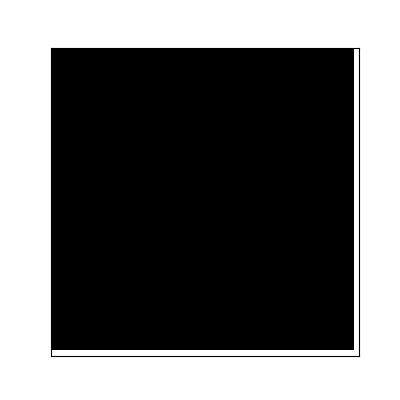

Button(description='reset', style=ButtonStyle())

Button(description='blur', style=ButtonStyle())

Button(description='predict', style=ButtonStyle())

Prediction: 5

In [14]:
dp = DrawingPad((28, 28), model_cnn)